In [26]:
!pip install vaderSentiment
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from scipy.stats import zscore, boxcox, iqr
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [27]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [29]:
file_path = "/content/twitter_training.csv"
df = pd.read_csv(file_path, encoding='utf-8')

In [30]:
df.columns = ["ID", "Category", "Sentiment", "Tweet"]
df.dropna(subset=["Tweet"], inplace=True)
df.drop_duplicates(inplace=True)

In [31]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    return text

In [32]:
df["Cleaned_Tweet"] = df["Tweet"].apply(clean_text)
stop_words = set(stopwords.words('english'))
df["Tokenized_Tweet"] = df["Cleaned_Tweet"].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

In [33]:
sia = SentimentIntensityAnalyzer()
df['VADER_Sentiment'] = df['Cleaned_Tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [34]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['Cleaned_Tweet']).toarray()

In [35]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr_value = iqr(df[column])
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [36]:
df = remove_outliers(df, 'VADER_Sentiment')

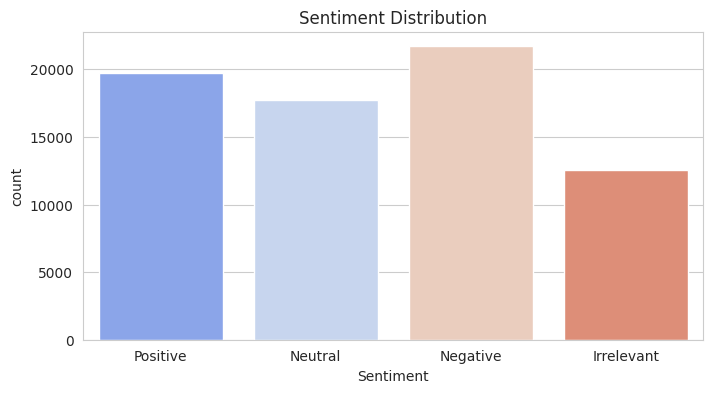

In [37]:
plt.figure(figsize=(8, 4))
sns.countplot(x=df["Sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.show()

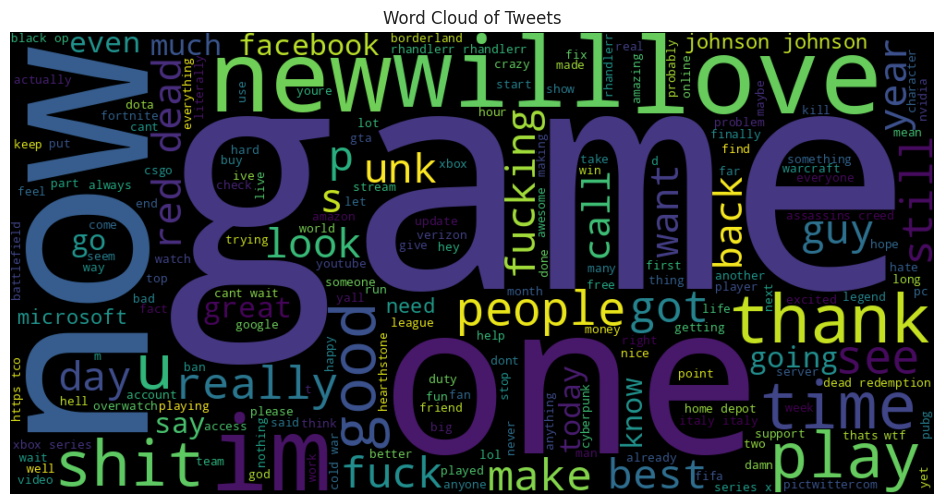

In [38]:
wordcloud = WordCloud(width=1000, height=500, background_color="black").generate(" ".join(df["Cleaned_Tweet"]))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Tweets")
plt.show()

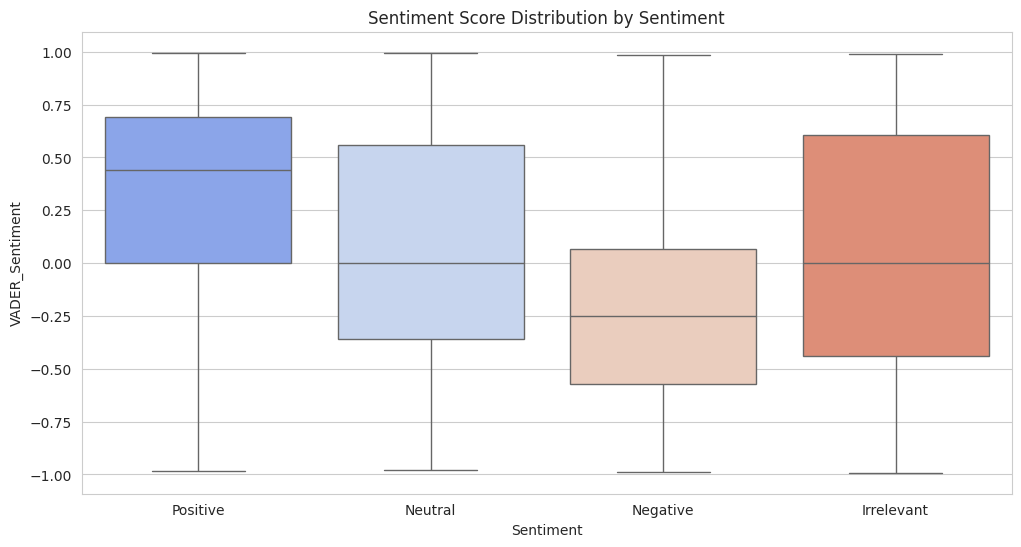

In [39]:
sns.boxplot(x=df['Sentiment'], y=df['VADER_Sentiment'], palette="coolwarm")
plt.title("Sentiment Score Distribution by Sentiment")
plt.show()

In [40]:
le = LabelEncoder()
df['Sentiment_Label'] = le.fit_transform(df['Sentiment'])
df['Tweet_Length'] = df['Cleaned_Tweet'].apply(len)
scaler = RobustScaler()
df['Tweet_Length_Scaled'] = scaler.fit_transform(df[['Tweet_Length']])

In [41]:
X = df[['Tweet_Length_Scaled']]
pca = PCA(n_components=1)
df['PCA_Feature'] = pca.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['Sentiment_Label'], test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [43]:
import joblib
joblib.dump(model, 'sentiment_model.pkl')
print("Model saved successfully!")

Model saved successfully!


In [44]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.47330960854092524
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07      2455
           1       0.41      0.94      0.57      4433
           2       0.81      0.17      0.27      3532
           3       0.58      0.49      0.53      3911

    accuracy                           0.47     14331
   macro avg       0.70      0.41      0.36     14331
weighted avg       0.66      0.47      0.40     14331

Confusion Matrix:
 [[  94 1730   29  602]
 [   0 4178   53  202]
 [   0 2359  584  589]
 [   0 1932   52 1927]]


In [45]:
sentiment_counts = df.groupby('Sentiment').count()['Tweet']
adf_test = adfuller(sentiment_counts)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: -42.94859639343235
p-value: 0.0


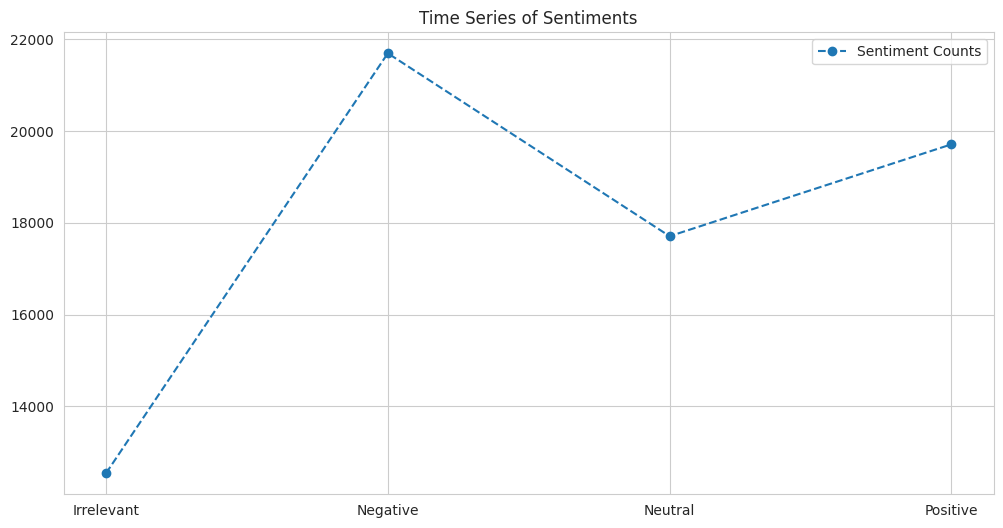

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts, marker='o', linestyle='dashed', label='Sentiment Counts')
plt.title("Time Series of Sentiments")
plt.legend()
plt.show()

In [48]:
model = ARIMA(sentiment_counts, order=(2, 1, 2))
model_fit = model.fit()
predictions = model_fit.predict(start=len(sentiment_counts), end=len(sentiment_counts) + 10)

In [49]:
import joblib
joblib.dump(model_fit, 'arima_sentiment_model.pkl')
print("ARIMA model saved successfully!")

ARIMA model saved successfully!


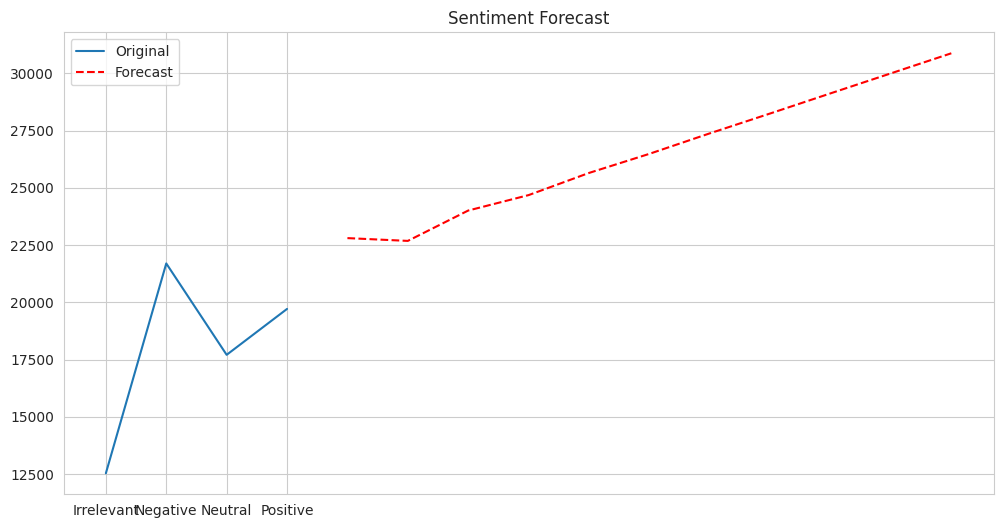

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts, label='Original')
plt.plot(predictions, label='Forecast', linestyle='dashed', color='red')
plt.legend()
plt.title("Sentiment Forecast")
plt.show()